In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
os.chdir("/content/drive/MyDrive/CSCI_5541_project")

print(os.getcwd())  # Now it will correctly show the new path

/content/drive/.shortcut-targets-by-id/18JrDTOVshdB2occqkUKCJGQhBEu3Gzsr/CSCI_5541_project


In [ ]:
!pip install datasets

In [ ]:
# Step 4: Now import torch freshly from your local user install
import torch
import torchaudio
import pandas as pd
from transformers import AutoProcessor, AutoModelForSpeechSeq2Seq, pipeline
from datasets import load_dataset, Audio
import pickle
import numpy as np

print("Everything imported successfully!")

Everything imported successfully!


In [ ]:
import pandas as pd

# Load all your parquet files
df = pd.read_parquet("nghe_an.parquet")
# df_hanoi = pd.read_parquet("hanoi.parquet")
# df_hue = pd.read_parquet("hue.parquet")
# df_saigon = pd.read_parquet("saigon.parquet")

# # Combine them
# df = pd.concat([df_nghe_an, df_hanoi, df_hue, df_saigon], ignore_index=True)

# # Done! Now check
print(df.shape)
print(df.head())

(280, 8)
    region  province_code province_name     filename  \
0  Central             37        NgheAn  37_0001.wav   
1  Central             37        NgheAn  37_0002.wav   
2  Central             37        NgheAn  37_0003.wav   
3  Central             37        NgheAn  37_0004.wav   
4  Central             37        NgheAn  37_0005.wav   

                                                text    speakerID  gender  \
0  Trẻ em thành phố hiện nay ngoài học thêm và ở ...  spk_37_0001       0   
1  Dịp này cháu nghỉ hè, phải cho cháu về quê. Cò...  spk_37_0002       0   
2  Chơi dưới đường thì cũng không được an toàn bở...  spk_37_0003       1   
3  Trên địa bàn thị xã Cửa Lò thiếu những cái điể...  spk_37_0004       1   
4  Về cái quy hoạch, tổng thể trước đây thì không...  spk_37_0005       1   

                                               audio  
0  {'array': [9.1552734375e-05, 6.103515625e-05, ...  
1  {'array': [0.00048828125, 0.00067138671875, 0....  
2  {'array': [0.0003967285

In [ ]:
# df.to_parquet("combined_provinces.parquet")

In [ ]:
print(df["province_name"].unique())
print(df.shape)
print(df['audio'][0])

['NgheAn']
(280, 8)
{'array': array([9.15527344e-05, 6.10351562e-05, 0.00000000e+00, ...,
       1.73645020e-02, 2.27050781e-02, 1.90429688e-02]), 'path': '37_0001.wav', 'sampling_rate': 44100}


In [ ]:
import torchaudio
import torch
import numpy as np

def resample_audio(df, target_sampling_rate=16000):
    print("Resampling audio to 16kHz...")

    for i in range(len(df)):
        original_waveform = np.array(df.loc[i, "audio"]["array"])
        original_waveform = torch.from_numpy(original_waveform).float()

        original_sampling_rate = df.loc[i, "audio"]["sampling_rate"]

        # Only resample if different from target
        if original_sampling_rate != target_sampling_rate:
            resampler = torchaudio.transforms.Resample(orig_freq=original_sampling_rate, new_freq=target_sampling_rate)
            resampled_waveform = resampler(original_waveform)

            # Update
            df.at[i, "audio"]["array"] = resampled_waveform.numpy()
            df.at[i, "audio"]["sampling_rate"] = target_sampling_rate

    print("Resampling complete!")
    return df

In [ ]:
df = resample_audio(df)

Resampling audio to 16kHz...
Resampling complete!


In [ ]:
from sklearn.model_selection import train_test_split

# First split: train and temp (val + test)
train_df, temp_df = train_test_split(
    df,
    test_size=0.1,
    random_state=42,
    # stratify=df["province_name"]  # <<< stratify by province_name
)

# Second split: validation and test
val_df, test_df = train_test_split(
    temp_df,
    test_size=0.5,
    random_state=42,
    # stratify=temp_df["province_name"]  # <<< stratify by province_name again
)

print(f"Train size: {len(train_df)}")
print(f"Val size: {len(val_df)}")
print(f"Test size: {len(test_df)}")

Train size: 252
Val size: 14
Test size: 14


In [ ]:
from torch.utils.data import Dataset

class WhisperDataset(Dataset):
    def __init__(self, df, processor):
        self.df = df
        self.processor = processor

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        audio = self.df.iloc[idx]["audio"]["array"]
        sampling_rate = self.df.iloc[idx]["audio"]["sampling_rate"]
        text = self.df.iloc[idx]["text"]
        province_name = self.df.iloc[idx]["province_name"]  # <-- use province_name here

        inputs = self.processor(audio, sampling_rate=sampling_rate, return_tensors="pt")
        labels = self.processor.tokenizer(text, return_tensors="pt")

        input_values = inputs.input_features.squeeze(0)
        labels = labels.input_ids.squeeze(0)

        return {
            "input_features": input_values,
            "labels": labels,
            "province_name": province_name  # <-- return province_name
        }


In [ ]:
from dataclasses import dataclass
from typing import Any, List, Dict, Union
import torch

@dataclass
class DataCollatorSpeechSeq2SeqWithPadding:
    processor: Any
    padding: Union[bool, str] = True

    def __call__(self, features: List[Dict[str, Any]]) -> Dict[str, Any]:
        input_features = [{"input_features": feature["input_features"]} for feature in features]
        label_features = [{"input_ids": feature["labels"]} for feature in features]
        regions = [feature["province_name"] for feature in features]  # <-- Collect province_name manually

        batch = self.processor.feature_extractor.pad(
            input_features,
            padding=self.padding,
            return_tensors="pt"
        )

        labels_batch = self.processor.tokenizer.pad(
            label_features,
            padding=self.padding,
            return_tensors="pt"
        )

        labels = labels_batch["input_ids"].masked_fill(labels_batch["input_ids"] == self.processor.tokenizer.pad_token_id, -100)

        batch["labels"] = labels
        batch["province_name"] = regions  # <-- Add province_name to the batch

        return batch


In [ ]:
from transformers import AutoProcessor

# Load the PhoWhisper processor
processor = AutoProcessor.from_pretrained("vinai/PhoWhisper-large")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


In [ ]:
data_collator = DataCollatorSpeechSeq2SeqWithPadding(processor=processor)

In [ ]:
!pip install evaluate
!pip install jiwer
!pip install bert_score

In [ ]:
import evaluate

# Load evaluation metrics
wer_metric = evaluate.load("wer")
bert_score_metric = evaluate.load("bertscore")

# 4. Define metric functions
def compute_metrics(predictions, references):
    wer = wer_metric.compute(predictions=predictions, references=references)
    bertscore = bert_score_metric.compute(predictions=predictions, references=references, lang="vi")
    return {
        "wer": wer,
        "bertscore_precision": sum(bertscore["precision"]) / len(bertscore["precision"]),
        "bertscore_recall": sum(bertscore["recall"]) / len(bertscore["recall"]),
        "bertscore_f1": sum(bertscore["f1"]) / len(bertscore["f1"]),
    }

In [ ]:
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")
print("Using device:", device)

Using device: cuda


In [ ]:
from transformers import AutoModelForSpeechSeq2Seq

# Load the PhoWhisper model
model = AutoModelForSpeechSeq2Seq.from_pretrained(
    "vinai/PhoWhisper-large",
)
model = model.to(device)

In [ ]:
from torch.utils.data import DataLoader

# Create datasets
train_dataset = WhisperDataset(train_df, processor)
val_dataset = WhisperDataset(val_df, processor)
test_dataset = WhisperDataset(test_df, processor)

# 4. Define Dataloaders
train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, collate_fn=data_collator)
val_loader = DataLoader(val_dataset, batch_size=3, shuffle=False, collate_fn=data_collator)
test_loader = DataLoader(test_dataset, batch_size=3, shuffle=False, collate_fn=data_collator)


In [ ]:
import torch
from torch.optim import AdamW
from tqdm import tqdm

# 3. Define optimizer
# optimizer = AdamW(model.parameters(), lr=1e-5)

import matplotlib.pyplot as plt

def train_model(model, train_loader, val_loader, optimizer, num_epochs=5):
    print("Starting manual training...")

    best_wer = float("inf")
    best_model_path = None

    # Track metrics
    train_losses = []
    val_wers = []
    val_bertscores = []

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        progress_bar = tqdm(train_loader, desc=f"Training Epoch {epoch+1}")

        for batch in progress_bar:
            input_features = batch["input_features"].to(device)
            labels = batch["labels"].to(device)

            optimizer.zero_grad()
            outputs = model(input_features=input_features, labels=labels)
            loss = outputs.loss

            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            progress_bar.set_postfix({"loss": loss.item()})

        avg_train_loss = running_loss / len(train_loader)
        train_losses.append(avg_train_loss)
        print(f"Epoch {epoch+1} Average Training Loss: {avg_train_loss:.4f}")

        # Evaluate
        metrics = evaluate_model(model, val_loader)
        val_wers.append(metrics["wer"])
        val_bertscores.append(metrics["bertscore_f1"])

        # Save checkpoint
        save_path = f"./pho_whisper_finetuned/model_epoch_{epoch+1}.pt"
        torch.save(model.state_dict(), save_path)
        print(f"Saved model checkpoint: {save_path}")

        if metrics["wer"] < best_wer:
            best_wer = metrics["wer"]
            best_model_path = save_path
            print(f"New best model found at {save_path} with WER {best_wer:.4f}")

    # Load best model
    if best_model_path:
        print(f"\nLoading best model from {best_model_path} with WER {best_wer:.4f}")
        model.load_state_dict(torch.load(best_model_path))

    # Save final model
    optimizer_name = optimizer.__class__.__name__
    learning_rate = optimizer.param_groups[0]['lr']
    model_filename = f"./pho_whisper_finetuned/final_model_{optimizer_name}_lr{learning_rate}.pt"
    torch.save(model.state_dict(), model_filename)
    # torch.save(model.state_dict(), "./pho_whisper_finetuned/final_model.pt")
    print("Training complete! Final model saved.")

    # Plot metrics
    epochs = list(range(1, num_epochs + 1))

    plt.figure(figsize=(15, 4))

    plt.subplot(1, 3, 1)
    plt.plot(epochs, train_losses, label="Train Loss")
    plt.title("Training Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")

    plt.subplot(1, 3, 2)
    plt.plot(epochs, val_wers, label="Validation WER", color="orange")
    plt.title("Validation WER")
    plt.xlabel("Epoch")
    plt.ylabel("WER")

    plt.subplot(1, 3, 3)
    plt.plot(epochs, val_bertscores, label="BERTScore F1", color="green")
    plt.title("Validation BERTScore F1")
    plt.xlabel("Epoch")
    plt.ylabel("F1 Score")

    plt.tight_layout()
    learning_rate = optimizer.param_groups[0]['lr']
    plt.savefig(f"./plot_output/metrics_plot_{optimizer.__class__.__name__}_lr{learning_rate}.png") # Save to file
    plt.show()

  # 6. Define evaluation function
def evaluate_model(model, val_loader):
    print("Evaluating on validation set...")
    model.eval()

    decoded_preds = []
    decoded_labels = []

    with torch.no_grad():
        for batch in tqdm(val_loader, desc="Evaluating"):
            input_features = batch["input_features"].to(device)
            labels = batch["labels"].to(device)

            outputs = model.generate(input_features=input_features, max_length=225)
            pred_texts = processor.batch_decode(outputs, skip_special_tokens=True)
            label_texts = processor.batch_decode(labels, skip_special_tokens=True)

            decoded_preds.extend(pred_texts)
            decoded_labels.extend(label_texts)

    # Compute both WER and BERTScore
    metrics = compute_metrics(decoded_preds, decoded_labels)
    print(f"Validation WER: {metrics['wer']:.4f}")
    print(f"Validation BERTScore F1: {metrics['bertscore_f1']:.4f}")

    return metrics

In [ ]:
# 7. Define test function
def test_model(model, test_loader, output_csv_path="test_predictions.csv"):
    print("Running predictions on test set...")
    model.eval()

    decoded_preds = []
    decoded_labels = []
    province_names = []  # <-- Rename from regions to province_names

    with torch.no_grad():
        for batch in tqdm(test_loader, desc="Testing"):
            input_features = batch["input_features"].to(device)
            labels = batch["labels"].to(device)
            batch_province_names = batch["province_name"]

            outputs = model.generate(input_features=input_features, max_length=225)
            pred_texts = processor.batch_decode(outputs, skip_special_tokens=True)
            label_texts = processor.batch_decode(labels, skip_special_tokens=True)

            decoded_preds.extend(pred_texts)
            decoded_labels.extend(label_texts)
            province_names.extend(batch_province_names)  # <-- Use province_names

    # Save CSV with province_name, reference text, prediction text
    results_df = pd.DataFrame({
        "province_name": province_names,  # <-- Here too
        "reference_text": decoded_labels,
        "prediction_text": decoded_preds,
    })
    results_df.to_csv(output_csv_path, index=False)
    print(f"Test predictions saved to {output_csv_path}")

    # Compute overall metrics
    overall_metrics = compute_metrics(decoded_preds, decoded_labels)
    print(f"Overall Test WER: {overall_metrics['wer']:.4f}")
    print(f"Overall Test BERTScore F1: {overall_metrics['bertscore_f1']:.4f}")

    # Compute metrics **per province_name**
    print("\nPer-province metrics:")
    for province_name in sorted(set(province_names)):
        province_preds = [p for p, prov in zip(decoded_preds, province_names) if prov == province_name]
        province_labels = [l for l, prov in zip(decoded_labels, province_names) if prov == province_name]

        province_metrics = compute_metrics(province_preds, province_labels)

        print(f"- {province_name}:")
        print(f"  WER: {province_metrics['wer']:.4f}")
        print(f"  BERTScore F1: {province_metrics['bertscore_f1']:.4f}")

    return results_df, overall_metrics



In [ ]:
# # Call it:
# results_df, test_metrics = test_model(model, test_loader, output_csv_path="test_predictions_pretrain.csv")

In [ ]:
from torch.optim import Adam
from torch.optim import SGD

Starting manual training...


Training Epoch 1: 100%|██████████| 84/84 [02:19<00:00,  1.66s/it, loss=0.803]


Epoch 1 Average Training Loss: 1.3357
Evaluating on validation set...


Evaluating:   0%|          | 0/5 [00:00<?, ?it/s]Due to a bug fix in https://github.com/huggingface/transformers/pull/28687 transcription using a multilingual Whisper will default to language detection followed by transcription instead of translation to English.This might be a breaking change for your use case. If you want to instead always translate your audio to English, make sure to pass `language='en'`.
The attention mask is not set and cannot be inferred from input because pad token is same as eos token. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Evaluating: 100%|██████████| 5/5 [00:32<00:00,  6.54s/it]


Validation WER: 0.2055
Validation BERTScore F1: 0.9143
Saved model checkpoint: ./pho_whisper_finetuned/model_epoch_1.pt
New best model found at ./pho_whisper_finetuned/model_epoch_1.pt with WER 0.2055


Training Epoch 2: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, loss=1.25]


Epoch 2 Average Training Loss: 1.2616
Evaluating on validation set...


Evaluating: 100%|██████████| 5/5 [00:32<00:00,  6.44s/it]


Validation WER: 0.2055
Validation BERTScore F1: 0.9143
Saved model checkpoint: ./pho_whisper_finetuned/model_epoch_2.pt


Training Epoch 3: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, loss=1.23]


Epoch 3 Average Training Loss: 1.2194
Evaluating on validation set...


Evaluating: 100%|██████████| 5/5 [00:31<00:00,  6.32s/it]


Validation WER: 0.2055
Validation BERTScore F1: 0.9144
Saved model checkpoint: ./pho_whisper_finetuned/model_epoch_3.pt


Training Epoch 4: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, loss=1.01]


Epoch 4 Average Training Loss: 1.1849
Evaluating on validation set...


Evaluating: 100%|██████████| 5/5 [00:32<00:00,  6.48s/it]


Validation WER: 0.2055
Validation BERTScore F1: 0.9144
Saved model checkpoint: ./pho_whisper_finetuned/model_epoch_4.pt


Training Epoch 5: 100%|██████████| 84/84 [02:18<00:00,  1.65s/it, loss=1.73]


Epoch 5 Average Training Loss: 1.1684
Evaluating on validation set...


Evaluating: 100%|██████████| 5/5 [00:33<00:00,  6.77s/it]


Validation WER: 0.2055
Validation BERTScore F1: 0.9146
Saved model checkpoint: ./pho_whisper_finetuned/model_epoch_5.pt

Loading best model from ./pho_whisper_finetuned/model_epoch_1.pt with WER 0.2055
Training complete! Final model saved.


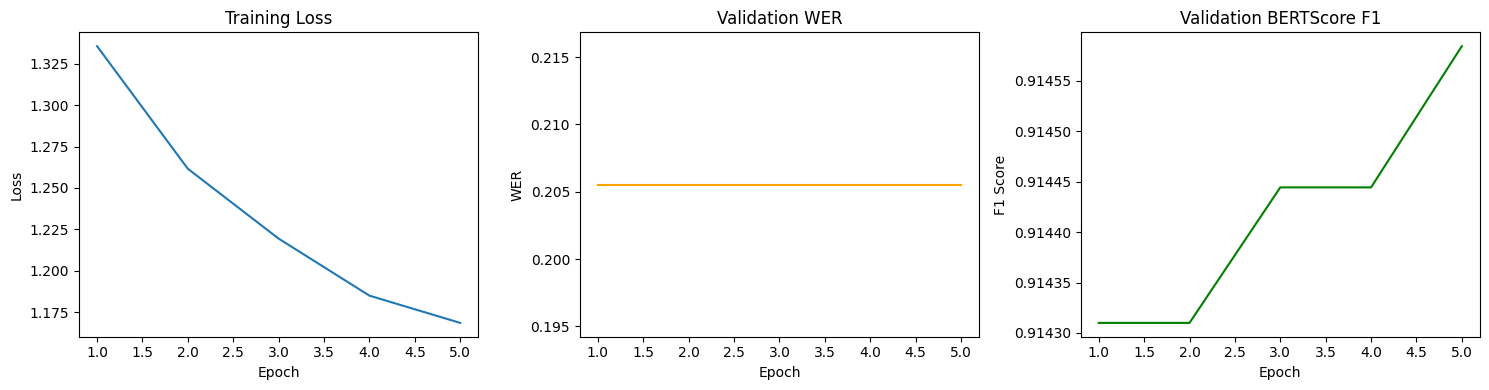

Running predictions on test set...


Testing: 100%|██████████| 5/5 [00:28<00:00,  5.61s/it]

Test predictions saved to ./csv_file_output/test_predictions_SGD_lr1e-06.csv
Overall Test WER: 0.2452
Overall Test BERTScore F1: 0.9122

Per-province metrics:
- NgheAn:
  WER: 0.2452
  BERTScore F1: 0.9122


In [ ]:
# Define optimizer
optimizer = SGD(model.parameters(), lr=1e-6)

# Train model (saves best and final model inside)
train_model(model, train_loader, val_loader, optimizer, num_epochs=5)

# Load final model (same naming as inside training function)
optimizer_name = optimizer.__class__.__name__
learning_rate = optimizer.param_groups[0]['lr']
model_filename = f"./pho_whisper_finetuned/final_model_{optimizer_name}_lr{learning_rate}.pt"
model.load_state_dict(torch.load(model_filename))

# Evaluate and export test results
csv_output_path = f"./csv_file_output/test_predictions_{optimizer_name}_lr{learning_rate}.csv"
results_df, test_metrics = test_model(model, test_loader, output_csv_path=csv_output_path)
